# **ADApocalypse presents:** "What do we do now ?"
by Coralie Banuls, Mahlia Merville-Hipeau, Juliette Le Béchec, Maximilien Gridel, Pernelle Paget

## Project Initialisation

### Import libraries

In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import json
from collections import defaultdict
#from transformers import pipeline
import ast
import re
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from statsmodels import tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

import folium
import geopandas as gpd
from folium import Choropleth, CircleMarker, Popup

# not displaying warnings
pd.options.mode.chained_assignment = None 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress all FutureWarnings from pandas

# to facilitate the use of py files
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [350]:
from src.data.data_loader import *
from src.data.data_transformer import *
from src.utils.visualization import *
from src.utils.methods import *

### Constants

In [351]:
COLOR_MALE = '#2D9884'
COLOR_FEMALE = '#6E17C6'
COLOR_MALE_LIGHT = '#17D07D'
COLOR_FEMALE_LIGHT = '#B56BEA'
COLOR_NEUTRAL = '#2D9884'
COLOR_PALETTE = {'M': COLOR_MALE, 'F': COLOR_FEMALE}

# 1. Loading file

We processed the data of each dataframe (detail in src/data/data_transformer) and computed the following functions once in order to generate the csv file :
- preprocess_movie_metadata()
- preprocess_char_metadata()
- preprocess_imdb_ratings(movies_metadata_df)
- preprocess_plot_emotions()

We applied the following rules to filter and preprocess the files: 
- all movies without release date were dropped
- all movies with a release date outside of the range 1910-2013 were dropped
- the release date were standardized into realase year
- thanks to another external dataset the missing gender were added
- the characters without a gender were dropped 

In order to fully understand the details behind the preprocessing, we refer you to the additional comments of each function definition and P2.
Then we compiled all of the data within 1 file thanks to the function preprocess_movies_complete(from_files).

We imported and transformed external datasets collected from different websites regarding :
- Bechdel Test API with preprocess_bechdel_ratings(df)
- TV Tropes (additional dataset) with preprocess_tvtropes(df)
- Metadata regarding Success (IMDB ratings, budget, box office revenue from TMDB dataset) with preprocess_movies_success()
- Movie Directors from wikipedia with get_director_name_and_gender() and preprocess_movies_director(wiki_movies_id)

We also preprocessed them in the src/data/data_transformer file. For information, some files are too big to be stored in the repository so all results are already pre run.


Loading the raw files from the CMU movie dataset.

In [352]:
movies_complete_df = preprocess_movies_complete(from_files=True) # to do once to generate the csv file

In [353]:
print(f'We now have {movies_complete_df.shape[0]} movies.')

We now have 60347 movies.


## 2. General Statistics about Movies

To explore our dataset, we first focused on general attributes of our database such as the distribution of movies by country, movie genre and across time.

In [354]:
# pre-processing the data
country_df = process_movies_by_country(movies_complete_df)

In [355]:
# plot the distribution of movies by countries
movies_by_country(country_df)

**Analysis**

We can see that we have a lot of movies from USA, UK, and Europe. Our analysis would be occidental-centered with an exception for India and north Asia countries. This highlights the overwhelming influence of the U.S. film industry in our database.

We can now wonder whether this american influence is also predominant considering movie genres.

In [356]:
# pre-processing the data
genre_df = process_movies_by_genre(movies_complete_df)

In [357]:
# plot the distribution of movies by genres
movies_by_genre(genre_df)

The first analysis of the movie genres give us a pretty good idea of the movie genres represented in our database, with predominantly Drama, Comedy, World Cinema and Romance movies. Our next focus is directed towards the number of movies released across time since the beginnning the of 20th Century.


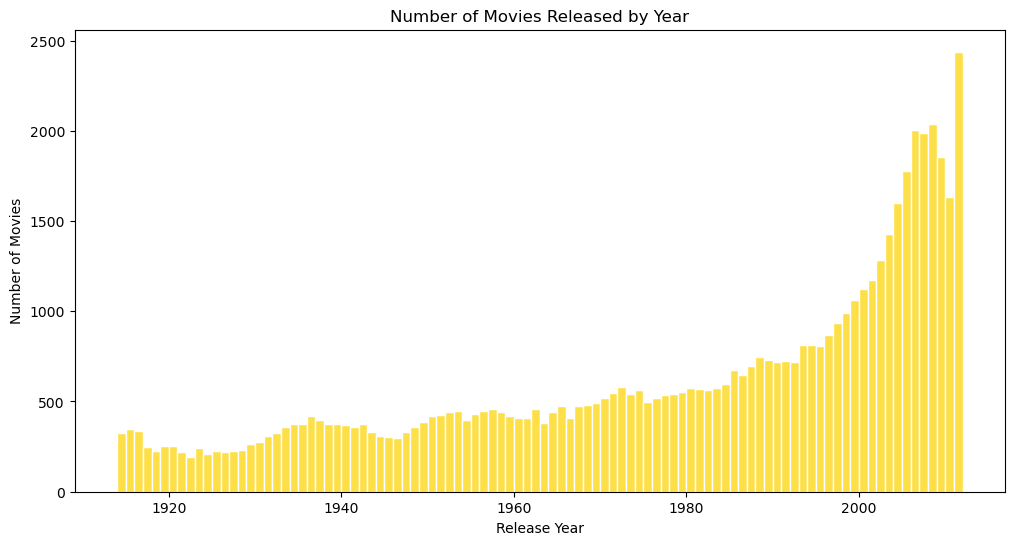

In [358]:
# plot the distribution of movies released by year
movies_per_year(movies_complete_df)

We can observe that the distribution of movies produced between 1910 until 2013 follows a heavy left-skewed distribution, with a notable increase since the 1980's. Indeed, whereas the number of movies produced present in our database barely reached 500 per year until the 1980, it impressively increased to reach about 2000 movies in the beginning of the 21th century.


# 3. Data Analysis

## A. Movie Directors

We are now diving straight into our theme by first looking at the gender distribution of movie directors.

In [359]:
# plot the distribution of genders amongst movie directors
plot_gender_distribution(movies_complete_df, 'director_gender')

**Analysis**

The number of movies in our dataset directed by a man is considerably higher than the ones directed by a woman. From this point on, we will mainly direct our analysis by comparing the result regarding the gender of the movie director in order to detect any tendancy.

## B. Female Actors / Characters

To pursue our analysis, we will focus on female representation within the movie industry. We will first look at the distribution of movie characters, and then link this data with specific features such as the age distribution, through time and space, as well as gender representation across movie genres.

### 1) Overview

In [360]:
# plot the distribution of genders amongst movie characters
plot_gender_distribution(movies_complete_df, 'actor_genders')

**Analysis**

This graph illustrates genre inequalities amongst actors. As we can see, overall only 1/3 of the actors are female.

### 2) Age Distribution

In [361]:
# pre-processing the data
female_female_percentage, female_male_percentage = process_actor_age(movies_complete_df.explode(['actor_genders', 'actor_age']), 'F')
male_female_percentage, male_male_percentage = process_actor_age(movies_complete_df.explode(['actor_genders', 'actor_age']), 'M')

In [362]:
# plot each age distribution
fig = go.Figure()
age_actors_by_dir(fig, female_female_percentage, "Fem. Directors: Fem. Actors", COLOR_FEMALE, 'solid')
age_actors_by_dir(fig, female_male_percentage, "Fem. Directors: Mal. Actors<br>", COLOR_FEMALE, 'dash')
age_actors_by_dir(fig, male_female_percentage, "Mal. Directors: Fem. Actors", COLOR_MALE, 'solid')
age_actors_by_dir(fig, male_male_percentage, "Mal. Directors: Mal. Actors", COLOR_MALE, 'dash')
age_actors_layout(fig)

**Analysis**

This graph illustrates the inequalities regarding opportunities given to older actors. Whereas the majority of male actors are between 30 and 50 years old, with an average of 40 years old, most women actors are only between 20 and 30 years old, with an average of 33 years old. The male actors seem to have a longer career than female ones.

### 3) Female Characters in movies

In [363]:
# plot female representation in movies by director
fem_representation_by_dir(movies_complete_df)

**Analysis**

Overall, Female Directors tend to represent more female actors than Male Directors. The proportion drastically dropped until 1942, with over a fourth of the characters represented by women. It then increased and stabilized at around 30-35%, where it steadily increased reaching 36% in 2013. Although the first half of the 20th Century was more unconclusive, World War II could be a reasonable explanation for it, since the 1980s, this tendancy seems to stabilize.

### 4) Across the globe

As primary investigation, we conducted a small analysis regarding the geographical provenance of the movies of our dataset as seen in part 2. We will now pursue our analysis by studying the average female representation in movies across the globe. 

In [31]:
# pre-processing of the data
gender_percentages_per_country_M = process_map_fem_char(movies_complete_df, "M", filter_movies=100)
gender_percentages_per_country_F = process_map_fem_char(movies_complete_df, "F", filter_movies=30)

In [32]:
# representation of female characters in movies across the globe
map_M = map_fem_char(gender_percentages_per_country_M, "M")
map_F = map_fem_char(gender_percentages_per_country_F, "F")

/Users/mahlia/Desktop/MA1/ADA/ada-2024-project-adapocalypse/src/utils/visualization.py:298: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

/Users/mahlia/Desktop/MA1/ADA/ada-2024-project-adapocalypse/src/utils/visualization.py:298: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



In [33]:
map_M

In [34]:
map_F

**Analysis**
The analysis of female character representation, particularly of average female character proportion per movie, shows clear differences across countries and depending on the gender of the director. For male-directed films, the Philippines (42.4%), Mexico (40.9%), and Japan (40.5%) rank highest, while Russia (28.8%) and Denmark (29.6%) show the lowest proportions. Female-directed films fare best in Sweden, where nearly half of the characters are women, but countries like Denmark (34.8%), Japan, China, and India lag behind.
Interestingly, Denmark consistently ranks among the worst for female representation, regardless of the director’s gender. Japan flips its position, ranking high in male-directed movies but falling behind for female-directed ones.


### 5) Character distribution over movie genres

From our initial analysis, we obtained the following graph depicting the general tendancy of movies. From this distribution of movies by genre, we then selected the top-10 genres and looked at the gender distribution on them. 

In [364]:
# pre-processing of the data
male_genre_percentages_top10 = process_top10_genres(movies_complete_df[movies_complete_df["director_gender"] == "M"])
female_genre_percentages_top10 = process_top10_genres(movies_complete_df[movies_complete_df["director_gender"] == "F"])

In [365]:
# character gender representation across top-10 Genres
plot_top10_genres(male_genre_percentages_top10, "Male")
plot_top10_genres(female_genre_percentages_top10, "Female")

Overall, male representation is mainly represented across different movie genres. As expected, the number of female actors is overall higher if the movie director is a woman. For example, we can observe an increase of the number of female actors by 7-8% in the top-3 movie genres : Drama, Comedy and World Cinema. In both cases, the genre where women are the most represented is Romance.

In [366]:
# plot gender distribution of actors
genres_most_fem_char(movies_complete_df[movies_complete_df["director_gender"] == "M"], "Male", sort=False, title="Highest")
genres_most_fem_char(movies_complete_df[movies_complete_df["director_gender"] == "F"], "Female", sort=False, title="Highest")

genres_most_fem_char(movies_complete_df[movies_complete_df["director_gender"] == "M"], "Male", sort=True, title="Poorest")
genres_most_fem_char(movies_complete_df[movies_complete_df["director_gender"] == "F"], "Female", sort=True, title="Poorest")

**Analysis**

Interestingly, the movie genre in which female actors appear the most are related to sexuality : LGBTQ, Erotic and Adult Film and Romance, regardless of the gender of the movie director. This highlights how deeply ingrained the stereotypes of the sexualization of women are in society.

On the other side, male directors tend to have a percentage of female actors inferior to 25% when filming historical / western movies whereas female directors are more likely to cast more actresses in their movies (lowest average of 32.5% in Action movies).

## C. TV TROPES

Here, we use an enhanced additional dataset, that gives us directly if genderdness of the trope. It was calculated using a ratio between male and female characteres playing the role and we refer to the paper that created the method (cf. README) for more information.

In [367]:
filtered_tropes, genderedness_df = preprocess_tvtropes(movies_complete_df) # to do once to generate the csv file

Loaded data from data/raw/tvtropes.clusters.txt, shape: (500, 2)
Loaded data from src/data/external_data/film_tropes.csv, shape: (751594, 6)
Loaded data from src/data/external_data/genderedness_filtered.csv, shape: (20931, 9)


In [368]:
final_tropes_F = get_dominant_tropes(filtered_tropes, genderedness_df, dominant="FemaleTokens", non_dominant="MaleTokens")
print(f"Female tropes mostly represented:\n", final_tropes_F["Trope"])

Female tropes mostly represented:
 0           FinalGirl
1          BrokenBird
2          DumbBlonde
3     BrainlessBeauty
4          ValleyGirl
5    ClassyCatBurglar
Name: Trope, dtype: object


In [369]:
final_tropes_M = get_dominant_tropes(filtered_tropes, genderedness_df, dominant="MaleTokens", non_dominant="FemaleTokens")
print(f"Male tropes mostly represented:\n", final_tropes_M.head(6)["Trope"])

Male tropes mostly represented:
 0                     DirtyCop
1                  ByronicHero
2                PsychoForHire
3             HenpeckedHusband
4              MasterSwordsman
5    CorruptCorporateExecutive
Name: Trope, dtype: object


In [370]:
# pre-processing of the data
male_director_data, female_director_data, male_director_top, female_director_top = preprocessing_final_tropes(final_tropes_F, final_tropes_M)

In [371]:
print(f"Male director - top of most represented tropes:\n {male_director_top["Trope"].head(8)} ")
print(f"\nFemale director - top of most represented tropes:\n {female_director_top["Trope"].head(8)} ")

Male director - top of most represented tropes:
 0                    FinalGirl
0                     DirtyCop
5    CorruptCorporateExecutive
2                PsychoForHire
2                   DumbBlonde
9                 TranquilFury
7                     JerkJock
1                   BrokenBird
Name: Trope, dtype: object 

Female director - top of most represented tropes:
 0           FinalGirl
2          DumbBlonde
4          ValleyGirl
3     BrainlessBeauty
42         SurferDude
22       ChildProdigy
1         ByronicHero
1          BrokenBird
Name: Trope, dtype: object 


**Analysis**

Here, we only plotted the categories that have some female characters. As expected following societal cliches, female characters are often juged based on their appearance (ex :"dumb blond") whereas more flatterous characters are predominantly males such as "byronic_hero" or "master_swodsman". Some categories are 100% female characters: chanteuse, final_girl, ophelia, prima_donna, valley_girl. Indeed, some genders word are contained in the title of the tv tropes. As for the category brainless beauty, we observe it is almost 50-50 but considering there is really less female characters, it is obvious to see that it is disproportionate.


In [372]:
# plot trop distribution by movie director gender
plot_director_trope_pie_charts(male_director_data, female_director_data)

**Analysis**

Interestingly, male directors tends to represent more masculin tv tropes than feminin ones, which can be simply explained by the fact that the distribution of actresses within movies produced by male directors is significantly low. In comparison, female directors tends to represent more or less equally stereotypes regarding each gender.

### C.2. Investigating the link between tropes and genres

In [374]:
most_represented_tropes = male_director_top["Trope"].head(10).tolist() + female_director_top["Trope"].head(10).tolist()
all_tropes = top_genres(df=filtered_tropes, big_cols=["Trope", "movie_genres"], less_cols=["Trope"])
all_tropes[all_tropes["Trope"].isin(most_represented_tropes)]

,Trope,movie_genres
5,BrainlessBeauty,"[Comedy, Drama, Romance]"
6,BrokenBird,"[Drama, Thriller, Comedy]"
9,ByronicHero,"[Drama, Adventure, Action]"
10,ChildProdigy,"[Drama, Family's Films, Comedy]"
13,CorruptCorporateExecutive,"[Adventure, Thriller, Drama]"
14,CrazyJealousGuy,"[Drama, Thriller, Comedy]"
18,DirtyCop,"[Thriller, Crime and Mystery, Drama]"
19,DumbBlonde,"[Comedy, Romance, Adventure]"
21,EccentricMentor,"[Adventure, Drama, Comedy]"
26,FinalGirl,"[Horror, Thriller, Comedy]"


**Analysis**

We can observe that the tropes appear usually in mainstream genres, such as Drama, Comedy, Romance. Usually, our female gendered tropes seem to have a lot of Romance, compared to the male tropes that seem to have more of Thriller, or Action.

## D. Role of Women in movies : Bechdel Test

### 1) Primary Analysis

The Bechdel Test is a test that evalutes the role and representation attributed to actresses in movies. The four possible results are :
- 0 : there is less than two female characters in the movie
- 1 : there are two female characters in the movie
- 2 : two female characters talk to each other
- 3 : two female characters talk to each other about something else than a man

With our initial analysis, we first intend to discover if the movies of our database tend to be sexist or not and further on whether the gender of the movie director has an influence on the result of the test.

In [7]:
bechdel_4_categories(movies_complete_df.dropna(subset=["bechdel_rating"]))

Here, this is the total distribution. As after, we will differentiate two categoris: fail (bringing together 0,1,2) / pass, we now plot the distributions together.

In [8]:
# pre-processing of the data
bechdel_corr_df = process_bechdel(movies_complete_df)

In [14]:
bechdel_2_categories(bechdel_corr_df)

**Analysis**

This graph shows the difference in success rates on the Bechdel test according to the gender of the director. We can see that, in proportion, female directors tend to produce movies that pass the Bechdel test more often than male directors.

### 1.1) Statistical test to know if the director gender and the bechdel result are correlated

From the last graph, we wonder if the director gender and the bechdel result are correlated. Thus, we conduct a t-test to find it out.

In [158]:
chi2_test(bechdel_corr_df[["director_gender", "bechdel_rating"]])

Observed Frequencies:
[[1457 1621]
 [ 150  315]]

Expected Frequencies:
[[1396.08975445 1681.91024555]
 [ 210.91024555  254.08975445]]

Chi-Square Statistic: 36.44952398316168
Degrees of Freedom: 1
P-Value: 1.5667138699186841e-09


The p-value is very small (1.57e-09), which suggests a significant association between director gender and Bechdel rating. This means the gender of the director has a notable influence on whether a movie passes or fails the Bechdel test.
A Chi-Square statistic of 36.45 indicates a strong deviation between the observed and expected frequencies. This high value suggests that the difference between the groups (director gender and bechdel result) is statistically significant, confirming their relationship.

### 2) When linked with sentiment analysis

We conducted a sentiment analysis on the plot summaries, using BERT Transformers.

In [121]:
# define specific dataframe
plot_emotions_df = process_df_emotions(movies_complete_df)

In [122]:
# pre-processing of data
emotion_scores = process_emotion_scores(plot_emotions_df)

In [124]:
# plot emotions in plot summaries
graph_emotions(emotion_scores)

**Analysis**

We see that more film summaries are categorised as including anger, whereas few contain joy or surprise. For further analysis, we want to investigate the potential relationship between the emotions and the genders of the main actors.

In [125]:
# pre-processing of data
ratios_women, ratios_men = process_emotion_by_dir_gender(plot_emotions_df)

In [127]:
# plot ratio of emotions by gender
graph_ratio_emotion_by_director_gender(ratios_women, ratios_men)

**Analysis**

We see a difference in the emotions present depending on the director's gender, particularly that of sadness and joy, which are more represented among women directors. On the opposite, men tend to represent anger and fear more. However, some emotions are represented equally, such as disgust and surprise.

We could analyze this saying sadness and joy are more female gendered emotions. Whereas anger, on the other hand is more male gendered in the common stereotypes.
The paper titled "The Gender Stereotyping of Emotions" by E. Ashby Plant, Janet Shibley Hyde, D. Michelle Keltner, and Janet L. Devine, published in 2000 in the journal Psychology of Women Quarterly, examines how emotions are perceived differently based on gender stereotypes. 

The study founds that participants believed women experience and express emotions such as sadness, and sympathy more frequently than men, while emotions like anger and pride were thought to be more common in men. 

### 2.2) When linked with genres

In [375]:
top_genres(df=movies_complete_df.dropna(subset=["bechdel_rating"]), big_cols=["director_gender", "bechdel_rating", "movie_genres"], less_cols=["director_gender", "bechdel_rating"], top=5)

,director_gender,bechdel_rating,movie_genres
0,F,0.0,"[Drama, World Cinema, Thriller, Action, Crime ..."
1,F,1.0,"[Drama, Comedy, World Cinema, Romance, Thriller]"
2,F,2.0,"[Drama, World Cinema, Comedy, Romance, Horror]"
3,F,3.0,"[Drama, Comedy, World Cinema, Romance, Horror]"
4,M,0.0,"[Drama, Adventure, Action, Thriller, World Cin..."
5,M,1.0,"[Drama, Comedy, Adventure, Thriller, Action]"
6,M,2.0,"[Drama, Comedy, Romance, Adventure, Thriller]"
7,M,3.0,"[Drama, Comedy, Romance, Thriller, Horror]"


**Analysis**

As we expected since Drama is by far the biggest category of movies, it always appear in first position, usually followed by Comedy and World Cinema. This is what we expected since they are the three largest categories, that means the bechdel dataset is quite representative of the mainstream genres. Then, it seems like there is no particular rule for the top genres. They all can appear in all bechdel result categories.

### 3.1) Does your favorite movie pass the Bechdel Test ? - Logistic Regression

Here, we want to try to predict the output of the Bechdel test, without knowing the dialogues. We use all our CMU movie dataset, augmented with the IMDB and TMDB external datasets. We tried different methods: logistic regression, random forest classfier and decision tree classifier. Here, we present only the logistic regression that yielded to the best results: an accuracy of 66% on the test set.


The hard part was preprocessing the data: bringing together all datasets and formatting the columns correctly. We used one-hot encoding. In the end we have more than 130 features (release date, director gender, number of female characters, number of male characters, genres, countrie, emotions from the sentiment analysis, imdb ratings, budget, box office revenue). We splitted the data into a training and a test set following the ratio 80:20. We normalized the data. We refer to the logistic_regression_for_bechdel function for more details.

In [137]:
y_test, y_pred_test, log_reg_model, X_train = logistic_regression_for_bechdel(movies_complete_df)

The accuracy score for the TEST set is: 66.29%
The accuracy score for the TRAINING set is: 72.09%


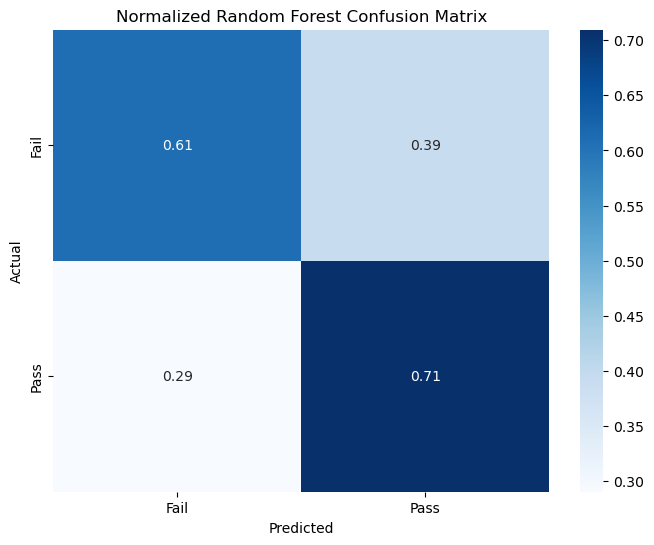

In [177]:
plot_confusion_matrix(y_test, y_pred_test)

**Analysis**

Here we have the confusion matrix of the machine learning model created to predict the success of different films in the Bechdel test. Here we see that the darker boxes correspond to true positive and true negative, which correspond to correctly classified results. We also notice that we obtain more false positives (0.39) than false negatives (0.29), which means that our model is more likely to predict that a film will pass the Bechdel test when in reality it will not. 

In [135]:
feature_importance(log_reg_model, X_train)

,Feature,Coefficient,Importance
7,char_F,1.113220,1.113220
6,char_M,-0.669976,0.669976
34,Feminist,0.433820,0.433820
91,Serbia,-0.230059,0.230059
100,Egypt,0.223698,0.223698
84,Lebanon,-0.217971,0.217971
112,Iceland,0.213767,0.213767
48,Plague,0.202891,0.202891
114,Taiwan,0.191121,0.191121
128,Colombia,0.189870,0.189870


In [ ]:
# calculate the correlation between the bechdel test result and interesting features
bechdel_corr_df = process_bechdel(movies_complete_df)

In [168]:
# statistical tests on the correlation hypothesis
corr_bechdel(bechdel_corr_df)

Correlation Results with Bechdel Rating:
Variable: char_F, Correlation: 0.35, P-Value: 4.935529762903264e-103 (Significant)
Variable: char_M, Correlation: -0.17, P-Value: 3.4528529262318984e-25 (Significant)

Chi-Square Test for Director Gender and Bechdel Rating:
Chi-Square Statistic: 36.45
P-Value: 1.5667138699186841e-09
Degrees of Freedom: 1
Observed Frequencies:
 [[1457 1621]
 [ 150  315]]
Expected Frequencies:
 [[1396.08975445 1681.91024555]
 [ 210.91024555  254.08975445]]


**Analysis**

We evaluate the features that had the greatest importance in the prediction of our model. We find out that the number of female characters and male characters are the too biggest. Thus, we want to represent their correlation to the bechdel result. We also display the correlation with the director gender, since this was our previous thought.
The analysis on the feature importance of our model shows that the number of female characters in a movie has a positive correlation with the Bechdel rating (0.35), meaning that more female characters increase the likelihood of passing the test. This result is understandable as the Bechdel test success relies on female characters, talking to each other. This means that if the more women are present, the best chance they talk to each other of something else than a man, thus passing the test. On the other hand, the number of male characters has a negative correlation (-0.17), suggesting that more male characters are associated with a lower chance of passing: : if too many male characters are present in the movie, then the movie might fail the test.

The chi-square test for director gender and Bechdel rating indicates a statistically significant association (p-value = 1.57e-9), but the observed and expected frequencies are quite similar, meaning that the director's gender has only a slight influence on the Bechdel result compared to the number of female characters. When applying the test on the real data, we found out that the two variables were dependant.


### 3.2) Predicting the bechdel result of all our movies

In [170]:
preprocessed_df = preprocess_before_inference(movies_complete_df)

In [171]:
bechdel_predictions_df = obtain_prediction_bechdel(preprocessed_df)

In [181]:
plot_bechdel_predictions(bechdel_predictions_df)

**Analysis**
We used our previously trained machine learning model to predict whether the remaining films in our dataset would pass the bechdel or not. We see that according to our model, which has an accuracy of about 70%, the majority of the films in our dataset would not pass the bechdel. This is surprising, as in the 3000 movies where we have the bechdel results, the trend was inverted. Moreover, from our confusion matrix, we learned that our model had a tendency to classify the movie as passing the test, even if it was not (False Positive).

In [173]:
plot_df = preprocess_bechdel_ratings_by_dirctor_gender(preprocessed_df)

In [178]:
bechdel_test_obtain_with_ml_ratings_by_gender(plot_df)

**Analysis**
Here we have the results of our bechdel predictions accross the entire dataset according to the director's genre. We can see that there is still a significant difference between female directors who do better in the Bechdel than male directors. And more female directors pass the bechdel than male directors. 

Of course, the two last graphs must be taken into account with caution, as we only obtained 70%. This is more for curiosity. We understand that our entire dataset must be more diversed, with movies from all times and all genres.

### 3.3) Comparison of emotions in movies that pass or fail the bechdel test

In [182]:
# pre-processing of the data
bechdel_radar_df = preprocessing_bechdel_for_radar_graph(movies_complete_df)

In [30]:
# plot the graph
graph_emotions_bechdel_combined(bechdel_radar_df)

**Analysis**

We see that the difference between pass and fail the bechdel is quite similar on both graphs, especially regarding the anger and sadness emotions. The movies that pass have a tendency for sadness and on the opposite, movies that fail have a tendency for anger. This is linked to the paper about the emotions we mentionned previously: emotions are gendered.

Moreover, movies that fail for female directors have also tendencies to increase the fear and disgust emotions.

## E. Public and Financial Recognition - based on Bechdel

Here, we will evaluate the success of a movie, using its imdb rating, its box office revenue, its budget. We will compare the similarites and the differences of success between the movies that pass the bechdel or fail it.

### Overview

Exploring the dataset, we found some interesting numbers that concern our dataset without any prior treatment.

In [194]:
movies_complete_df.groupby('director_gender')['num_votes'].describe()

,count,mean,std,min,25%,50%,75%,max
director_gender,,,,,,,,
F,3035.0,10206.587479,39639.966169,51.0,262.0,1025.0,4227.0,745178.0
M,29137.0,21235.584274,94004.888879,51.0,371.0,1293.0,5981.0,2952726.0


By computing statistics proportional to the number of movies directed by each gender, we observe a consequent difference regarding the number of votes attributed to movie amongst genders. On average, movies directed by men will receive twice the amount of ratings compared to movies directed by women. This parameter is although not resistant against extreme values. By comparing the median, we observe a smaller difference. This reveals a presence of outliers, and more specifically popularity amongst certain movies directed by men.

In [195]:
# plot the average rating of movies by director gender
avg_rating(movies_complete_df)

The movies directed by women seem to be interestingly better rated than the ones directed by men, which demonstrates more public interest in movies directed by women.

From now on, we will keep our adapt our dataset by focusing on the Bechdel Test.

In [32]:
# pre-processing of data - "passed" & "failed" group
passed_df = movies_complete_df[movies_complete_df['bechdel_rating'] == 3]
failed_df = movies_complete_df[movies_complete_df['bechdel_rating'] <= 2]

After conducting a ranking-analysis of the film genres most prevalent in the remaining categories, we found that films that did not pass the Bechdel Test were predominantly westerns, historical films, action, adventure, and silent films. The inclusion of silent films is understandable, but the presence of the other genres can be explained by gender stereotypes. Indeed, these genres often feature male protagonists, leaving female characters in passive roles or as love interests. Interactions between female characters are often scarce or non-existent, which causes the Bechdel Test to fail. Our first thought was to pursue our analysis focusing only on these genres, associated with the result of the Bechdel Test in order to explore the "extremes". However, we did not find any remarquable difference and decided to redirect our focus on the result of the Bechdel Test only.

### 1) Public Recognition

While keeping our dataframes focusing on the result of the Bechdel Test, we will now compare the ratings depending on the gender of the movie director. What do you think ? Will a movie directed by a woman that break stereotypes be better received by the critique than a movie filled with stereotypes ?

In [33]:
# pre-processing of the data to plot average rating by bechdel test result and by movie director gender
ratings_passed_male, ratings_passed_female = process_ratings_bechdel(passed_df)
ratings_failed_male, ratings_failed_female = process_ratings_bechdel(failed_df)

In [34]:
# plot average rating of movies by bechdel test result and by movie director gender
avg_rating_bechdel(ratings_passed_female, ratings_failed_female, ratings_passed_male, ratings_failed_male)

**Analysis**

Interestingly, movies that fail the Bechdel test tend to be better ranked than the ones who pass the test, regardless of director gender. This statement is even stronger for female directors, for which more than 50% of the moviesfailing Bechdel received a grade greater than 7/10. 

Overall, movies that complete the Bechdel test are better ranked if they are directed by a man whereas female director giving visibility to actresses tend to be more persecuted by the critique.

We can now wonder whether such difference is also depicted in the economical success of the movie ?

### 2) Financial Success

Now focusing only on the success of movies depending on their Bechdel test, we first intended to uncover a tendancy regarding the box office revenue. Will a movie that breaks stereotypes be rewarded ?

In [207]:
# pre-processing of the data
revenue_passed_male, revenue_passed_female = process_revenue_bechdel(passed_df)
revenue_failed_male, revenue_failed_female = process_revenue_bechdel(failed_df)

In [228]:
# plot revenues depending on bechdel test result by director gender
revenue_bechdel(revenue_passed_male, revenue_passed_female, revenue_failed_male, revenue_failed_female)

**Analysis**

It seems that independently of the movie director gender, movies passing the Bechdel Test exhibit a broader and higher revenue range, on average slightly even more when directed by women. The difference is even stronger when focusing solely on women directors. Indeed, meaningful interaction between women approximately increases the box office revenue from 27 to 47 million dollars.


### 3) Relation between Public and Financial Recognition

In [219]:
# pre-processing of the dataset containing the movies that passed the Bechdel test, in oder to exclude na values
passed_df = passed_df.dropna(subset=['movie_budget', 'box_office_revenue', 'average_rating'])

In [220]:
# plot the relation between average rating, box office revenue, movie budgetand director gender within movies that passed the bechdel test
# the size of the scattered dots corresponds to the movie budgets
success_bechdel(passed_df)

**Analysis**

Focusing on female directors, the average rating of a movie does not seem to correlate with the box office revenue as the revenue seems to oscillate between 0 and 500 millions dollars independantly of the rating. Although, we can notice that movies rated less than 4.5 / 10 tend to have a smaller revenue.

Focusing on male directors, the range of box office revenue seems to divide into 3 groups seems to extend when better received by the critique. There is thus not a clear correlation between the two variables, although we can affirm that movies directed by men tends to obtain a bigger financial revenue.

Moreover, not only do female directors tend to earn little revenu compared to male directors no matter the popularity of the movie, less than 200 million for the majority of movies, but the tendancy is NOT the case in the opposite way. Indeed, movies directed by men seem to be rewarded economically when appreciated by the critique as they can bring billions of dollars, but also have the most important financial means.

Regarding the movie budget, it often exceeds 200 million when directed by men whereas barely reaches 80 million for the luckier movies directed by female, which once again displays  financial success disparities amongst genders.

In [221]:
# Calculate correlations rating - box office
df = movies_complete_df.dropna(subset=["box_office_revenue", "average_rating"])
for gender in df["director_gender"].unique():
    subset = df[df['director_gender'] == gender]
    pearson_corr, pearson_p = pearsonr(subset["average_rating"], subset["box_office_revenue"])
    spearman_corr, spearman_p = spearmanr(subset["average_rating"], subset["box_office_revenue"])
    print(f"{gender} Directors:")
    print(f"  - Pearson Correlation: {pearson_corr:.2f} with p-value:{pearson_p}")
    print(f"  - Spearman Correlation: {spearman_corr:.2f} with p-value:{spearman_p}")

M Directors:
  - Pearson Correlation: 0.17 with p-value:2.200404463950492e-39
  - Spearman Correlation: 0.14 with p-value:2.5086777388152573e-28
F Directors:
  - Pearson Correlation: 0.04 with p-value:0.3370766645609456
  - Spearman Correlation: -0.01 with p-value:0.7329003042736336


In [222]:
# Calculate correlations: rating - budget
df = movies_complete_df.dropna(subset=["movie_budget", "movie_release_date"])
for gender in df['director_gender'].unique():
    subset = df[df['director_gender'] == gender]
    pearson_corr, pearson_p = pearsonr(subset["movie_release_date"], subset["movie_budget"])
    spearman_corr, spearman_p = spearmanr(subset["movie_release_date"], subset["movie_budget"])
    print(f"{gender} Directors:")
    print(f"  - Pearson Correlation: {pearson_corr:.2f} with p-value: {pearson_p}")
    print(f"  - Spearman Correlation: {spearman_corr:.2f} with p-value: {spearman_p}")


M Directors:
  - Pearson Correlation: 0.32 with p-value: 3.0404089750056724e-155
  - Spearman Correlation: 0.37 with p-value: 9.454499519734486e-211
F Directors:
  - Pearson Correlation: 0.12 with p-value: 0.004288816620568519
  - Spearman Correlation: 0.00 with p-value: 0.9556028107400039


**Analysis**

Here, we test the correlation between the rating and box office revenue, then between the rating and the budget.
- rating / box office revenue:

The correlation between movie ratings and revenue for male directors shows a weak positive relationship, with Pearson (0.17) and Spearman (0.14) correlations both being statistically significant (p-value < 0.05). This suggests slightly higher revenue for better-rated movies directed by men.

For female directors, the correlations are very weak and not significant (Pearson: 0.04, Spearman: -0.01, p-values > 0.05), indicating no meaningful relationship between ratings and revenue for these movies.

Here, we observe a true difference of tendency according to the director gender.

- rating / budget:


For male directors, there is a moderate positive correlation between movie ratings and budget, with both Pearson (0.32) and Spearman (0.37) correlations being highly significant (p-values < 0.05). This suggests that higher-rated movies directed by men tend to have larger budgets.

For female directors, the Pearson correlation (0.12) is weak but significant (p-value < 0.05), indicating a slight positive relationship between ratings and budget. However, the Spearman correlation (0.00) is negligible and not significant (p-value > 0.05), suggesting that for female-directed movies, the rating does not meaningfully relate to the budget.

Here, we still observe a true difference of tendency according to the director gender, slightly less than for the rating / box office revenue.
